In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import optuna
import lightgbm as lgb
import pickle

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Load

In [2]:
data = pd.read_csv('C:\\Users\\이찬영\\Desktop\\House_Price\\train.csv')
sub = pd.read_csv('C:\\Users\\이찬영\\Desktop\\House_Price\\test.csv')

# Feature engineering

## Handle Missing

In [3]:
def handle_missing(df,Test = False):
    n_rows = df.shape[0]
    missing_val_count_by_column = pd.DataFrame(df.isnull().sum(),columns=['col_n_missing'])
    missing_val_count_by_column['col_perc_missing'] = round(100*(missing_val_count_by_column.col_n_missing/n_rows),2)
    missing_val_count_by_column['type'] = [df[c].dtype for c in missing_val_count_by_column.index]

    cols_complete = missing_val_count_by_column[missing_val_count_by_column.col_perc_missing == 0.0].index
    cols_num_w_missing = missing_val_count_by_column.loc[(missing_val_count_by_column.col_perc_missing > 0.0) & (missing_val_count_by_column.type != 'object')].index
    cols_cat_w_missing = missing_val_count_by_column.loc[(missing_val_count_by_column.col_perc_missing > 0.0) & (missing_val_count_by_column.type == 'object')].index
    garage_cat_cols = [col for col in cols_cat_w_missing if col.find('Garage') > -1]
    garage_num_cols = [col for col in cols_num_w_missing if col.find('Garage') > -1]
    garage_cols = [col for col in df.columns if col.find('Garage') > -1]
    garage_missing_index = df[garage_cols].loc[(df.GarageType.isnull() == True) &
                                (df.GarageYrBlt.isnull() == True) &
                                (df.GarageFinish.isnull() == True) &
                                (df.GarageQual.isnull() == True) &
                                (df.GarageCond.isnull() == True) &
                                (df.GarageCars == 0) &
                                (df.GarageArea == 0)
                                ].index
    df.loc[garage_missing_index,garage_cat_cols] = df.loc[garage_missing_index,garage_cat_cols].fillna(value='NA')
    df.loc[garage_missing_index,garage_num_cols] = df.loc[garage_missing_index,garage_num_cols].fillna(value=0)

    df.GarageFinish.fillna(value = 'Unf', inplace = True)
    df.GarageQual.fillna(value = 'TA', inplace = True)
    df.GarageCond.fillna(value = 'TA', inplace = True)

    df.GarageArea.fillna(value = 390, inplace = True)
    df.GarageCars.fillna(value = 1, inplace = True)

    bsmt_cat_cols = [col for col in cols_cat_w_missing if col.find('Bsmt') > -1]
    bsmt_num_cols = [col for col in cols_num_w_missing if col.find('Bsmt') > -1]
    bsmt_cols = [col for col in df.columns if col.find('Bsmt') > -1]
    bsmt_missing_index = df[bsmt_cols].loc[(df.BsmtExposure.isnull() == True) &
                        (df.BsmtCond.isnull() == True) &
                        (df.BsmtQual.isnull() == True) &
                        (df.BsmtFinType1.isnull() == True) &
                        (df.BsmtFinType2.isnull() == True) |
                        (df.BsmtFinSF1.isnull() == True) |
                        (df.BsmtFullBath.isnull() == True) |
                        (df.BsmtHalfBath.isnull() == True) |
                        (df.BsmtUnfSF.isnull() == True) |
                        (df.BsmtFinSF2.isnull() == True) |
                        (df.TotalBsmtSF.isnull() == True)
                    ].index

    df.loc[bsmt_missing_index,bsmt_cat_cols] = df.loc[bsmt_missing_index,bsmt_cat_cols].fillna(value='NA')
    df.loc[bsmt_missing_index,bsmt_num_cols] = df.loc[bsmt_missing_index,bsmt_num_cols].fillna(value=0)
    df.BsmtCond.fillna(value='TA',inplace=True)
    df.BsmtExposure.fillna(value='No',inplace=True)
    df.BsmtQual.fillna(value='TA',inplace=True)
    df.BsmtFinType2.fillna(value='Unf',inplace=True)

    masvnr_cat_cols = [col for col in cols_cat_w_missing if col.find('MasVnr') > -1]
    masvnr_num_cols = [col for col in cols_num_w_missing if col.find('MasVnr') > -1]
    masvnr_missing_index = df[['MasVnrArea','MasVnrType']].loc[(df.MasVnrType.isnull() == True) &
                                        (df.MasVnrArea.isnull() == True)
                                        ].index
    df.loc[masvnr_missing_index,masvnr_cat_cols] = df.loc[masvnr_missing_index,masvnr_cat_cols].fillna(value='NA')
    df.loc[masvnr_missing_index,masvnr_num_cols] = df.loc[masvnr_missing_index,masvnr_num_cols].fillna(value=0)
    df.MasVnrType.fillna(value='BrkFace',inplace=True)
    if Test:
      indexIDOTRR = [1916,2217,2251]
      indexMitch = [2905]
      df.loc[indexIDOTRR,'MSZoning'] = df.loc[indexIDOTRR,'MSZoning'].fillna(value='RM')
      df.loc[indexMitch,'MSZoning'] = df.loc[indexMitch,'MSZoning'].fillna(value='RL')

    df.Utilities.fillna(value='AllPub',inplace=True)
    df.Functional.fillna(value='Typ',inplace=True)
    df.Exterior1st.fillna(value='MetalSd',inplace=True)
    df.Exterior2nd.fillna(value='Wd Sdng',inplace=True)
    df.Electrical.fillna(value='SBrkr',inplace=True)
    df.KitchenQual.fillna(value='TA',inplace=True)
    df.SaleType.fillna(value='WD',inplace=True)


    # LotFrontage by median Neighborhood, MSZoning by mean MSSubClass
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    cols = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
    df[cols] = df[cols].fillna(value='NA')
    df.GarageYrBlt.fillna(value = 0, inplace = True)

    return df

## Transfrom numerical

In [4]:
def handle_numeric(df):
  cols = ['PoolArea', 'LowQualFinSF', '3SsnPorch', 'MiscVal', 'ScreenPorch', 'EnclosedPorch']

  df[cols] = np.log1p(df[cols])

  return df


## Transform categorical

In [5]:
def handle_ordinal(df):
    cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
            'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

    category_order = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
    category_order_cols = []
    for _ in range(len(cols)):
      category_order_cols.append(category_order)
    ordinal_encoder = OrdinalEncoder(categories=category_order_cols)
    ordinal_columns = ordinal_encoder.fit_transform(df[cols])
    df[cols] = ordinal_columns
    for col in cols:
        df[col] = df[col].astype('category')

    return df

encoder = None
def handle_nominal(df):

    cols = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical',
       'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass']

    global encoder
    if encoder is None:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoder.fit(df[cols])
    encoded_features = encoder.transform(df[cols])
    new_feature_names = encoder.get_feature_names_out(cols)
    df = df.join(pd.DataFrame(encoded_features, columns=new_feature_names))
    df.drop(columns=cols, inplace=True)

    for col in new_feature_names:
        df[col] = df[col].astype('category')

    return df

## More features

In [6]:
def create_new_features(df):
    cols = ['YearBuilt', 'YearRemodAdd']
    for col in cols:
        df[col + 'Age'] = 2024 - df[col]

    df['YearsSinceLastRemode'] = df['YrSold'] - df['YearRemodAdd']
    df['TotalSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBathrooms'] = df['FullBath'] +  df['BsmtFullBath'] + (0.5 * df['HalfBath']) + (0.5 * df['BsmtHalfBath'])

    return df

## All transformations

In [7]:
def transform(df, drop_id=True, Test = False, outliers = False):

    if drop_id:
        df.reset_index(inplace=True, drop=True)
        df.drop(columns=['Id'], inplace=True)

    df = handle_missing(df)
    df = handle_numeric(df)
    df = create_new_features(df)
    df = handle_ordinal(df)
    df = handle_nominal(df)

    return df

# Model

In [8]:
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(data.copy(), y, test_size=0.2, random_state=43, shuffle=True, stratify=None)
data.drop(columns=['SalePrice'], inplace=True)
X_train.drop(columns=['SalePrice'], inplace=True)
X_test.drop(columns=['SalePrice'], inplace=True)


data = transform(data)
X_train = transform(X_train)
X_test = transform(X_test)
submission = transform(sub, Test=True)

## GradientBoosting

In [9]:
def objective(trial):
    # Define the hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 0.03, 0.1, log=True)
    n_estimators = trial.suggest_int('n_estimators', 80, 250)
    max_depth = trial.suggest_int('max_depth', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 10, 120)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)

    # Initialize and train the Random Forest classifier with the hyperparameters
    classifier = GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Evaluate the classifier using cross-validation
    score = cross_val_score(classifier, X_train, np.log(y_train), cv=10, n_jobs=-1, scoring='neg_root_mean_squared_error').mean()

    return score

In [10]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

In [11]:
# print("Best hyperparameters: ", study.best_params)
# print("Best score: ", study.best_value)

In [12]:
best_params = {'learning_rate': 0.046811565921440715, 'n_estimators': 233, 'max_depth': 78, 'min_samples_split': 102, 'min_samples_leaf': 13}
gbr = GradientBoostingRegressor(**best_params, random_state=42)
gbr.fit(X_train, np.log(y_train))

GradientBoostingRegressor(learning_rate=0.046811565921440715, max_depth=78,
                          min_samples_leaf=13, min_samples_split=102,
                          n_estimators=233, random_state=42)

In [13]:
acc_test = mean_squared_error(np.log(y_test), gbr.predict(X_test), squared=False)

In [14]:
print (f'Accuracy test = {acc_test}')

Accuracy test = 0.14844386412194194


### Filter features by importance

In [15]:
df_feature = pd.DataFrame(columns=['feature_names', 'feature_importances'])
df_feature['feature_names'] = gbr.feature_names_in_
df_feature['feature_importances'] = gbr.feature_importances_
df_feature_filtered = df_feature[df_feature['feature_importances'] > 0.00001]
filtered_features = df_feature_filtered['feature_names']

In [16]:
gbr = GradientBoostingRegressor(**best_params, random_state=42)
gbr.fit(X_train[filtered_features], np.log(y_train))
acc_test = mean_squared_error(np.log(y_test), gbr.predict(X_test[filtered_features]), squared=False)
print (f'Accuracy test = {acc_test}')

Accuracy test = 0.14766445728580035


In [17]:
gradient_boosting_model = GradientBoostingRegressor(**best_params, random_state=42)
gradient_boosting_model.fit(data[filtered_features], np.log(y))

GradientBoostingRegressor(learning_rate=0.046811565921440715, max_depth=78,
                          min_samples_leaf=13, min_samples_split=102,
                          n_estimators=233, random_state=42)

## LGBM

In [18]:
train_data = lgb.Dataset(X_train, label=np.log(y_train))

def objective(trial):
    param = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": 0.02,

        "num_leaves": trial.suggest_int("num_leaves", 3, 20),
        "num_iterations": trial.suggest_int("num_iterations", 5000, 10000),
        "min_sum_hessian_in_leaf": trial.suggest_int("min_child_samples", 5, 20),

        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 0.5),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 2, 6),
        "verbosity": -1
    }

    res = lgb.cv(param, train_data, nfold=5, stratified=False)
    return res['valid rmse-mean'][-1]

In [19]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=200)

In [20]:
# print("Best hyperparameters: ", study.best_params)
# print("Best score: ", study.best_value)

In [21]:
gbm_best_params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.02,
    'num_leaves': 11,
    'num_iterations': 5166,
    'min_child_samples': 12,
    'feature_fraction': 0.29905049454786325,
    'bagging_fraction': 0.906037381299916,
    'bagging_freq': 6}

In [22]:
gbm = lgb.train(gbm_best_params, lgb.Dataset(X_train, label=np.log(y_train)))

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3882
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 202
[LightGBM] [Info] Start training from score 12.022187


In [23]:
acc_test = mean_squared_error(np.log(y_test), gbm.predict(X_test), squared=False)

In [24]:
print (f'Accuracy test = {acc_test}')

Accuracy test = 0.133443279536625


In [25]:
lgb_model = lgb.train(gbm_best_params, lgb.Dataset(data, label=np.log(y)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4157
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 210
[LightGBM] [Info] Start training from score 12.024051


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


## Ridge

In [26]:
def objective(trial):
    # Define the hyperparameters to tune
    alpha = trial.suggest_float("alpha", 0.001, 100)
    solver = trial.suggest_categorical("solver", ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])

    # Initialize and train the Random Forest classifier with the hyperparameters
    classifier = Ridge(alpha=alpha, solver=solver)

    # Evaluate the classifier using cross-validation
    score = cross_val_score(classifier, X_train, np.log(y_train), cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error').mean()

    return score

In [27]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=500)

In [28]:
# print("Best hyperparameters: ", study.best_params)
# print("Best score: ", study.best_value)

In [29]:
rdg = Ridge(alpha=14.93548147100569, solver='auto', random_state=42)
rdg.fit(X_train, np.log(y_train))

Ridge(alpha=14.93548147100569, random_state=42)

In [30]:
# acc_test = mean_squared_error(np.log(y_test), rdg.predict(X_test), squared=False)

In [31]:
# print (f'Accuracy test = {acc_test}')

# Analyze Results

## Predictions vs Actuals

In [32]:
gbr = GradientBoostingRegressor(**best_params, random_state=42)
gbr.fit(X_train[filtered_features], np.log(y_train))
pred_log = gbr.predict(X_test[filtered_features])
pred = np.exp(pred_log)
pred_vs_actual = pd.DataFrame(columns=['predicted', 'actual'])
pred_vs_actual['predicted'] = pred
pred_vs_actual['actual'] = list(y_test)
pred_vs_actual = pred_vs_actual.sort_values(by="actual").reset_index(drop=True)

In [33]:
fig = px.scatter(x=pred_vs_actual.index, y=pred_vs_actual.actual)
fig.add_scatter(x=pred_vs_actual.index, y=pred_vs_actual.predicted,  mode="markers")
fig.show()

In [34]:
pred_vs_actual.iloc[177]

predicted    542451.565627
actual       184750.000000
Name: 177, dtype: float64

In [35]:
data_orig = pd.read_csv('C:\\Users\\이찬영\\Desktop\\House_Price\\train.csv')
data_orig[data_orig['SalePrice'] == 184750]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


In [36]:
data_orig[data_orig['OverallQual'] == 10][['LotFrontage', 'LotArea', 'OverallQual', 'LandContour', 'LotConfig', 'Neighborhood', 'GrLivArea', 'SalePrice']] # 524 59

,LotFrontage,LotArea,OverallQual,LandContour,LotConfig,Neighborhood,GrLivArea,SalePrice
58,66.0,13682,10,HLS,CulDSac,StoneBr,2945,438780
185,90.0,22950,10,Lvl,Inside,OldTown,3608,475000
224,103.0,13472,10,Lvl,Inside,NridgHt,2392,386250
389,96.0,12474,10,Lvl,Inside,NridgHt,2332,426000
440,105.0,15431,10,Lvl,Inside,NridgHt,2402,555000
515,94.0,12220,10,Lvl,Inside,NridgHt,2020,402861
523,130.0,40094,10,Bnk,Inside,Edwards,4676,184750
583,75.0,13500,10,Lvl,Inside,OldTown,2775,325000
591,97.0,13478,10,Lvl,Corner,NridgHt,2296,451950
691,104.0,21535,10,Lvl,Corner,NoRidge,4316,755000


In [37]:
import shap
explainer = shap.TreeExplainer(gbr)

## 523 & 1297 이상치
- SalePrice 값 대비 OverallQual 값이 큰 편에 속한다.
  - OverallQual: 10 -> 6 으로 수정

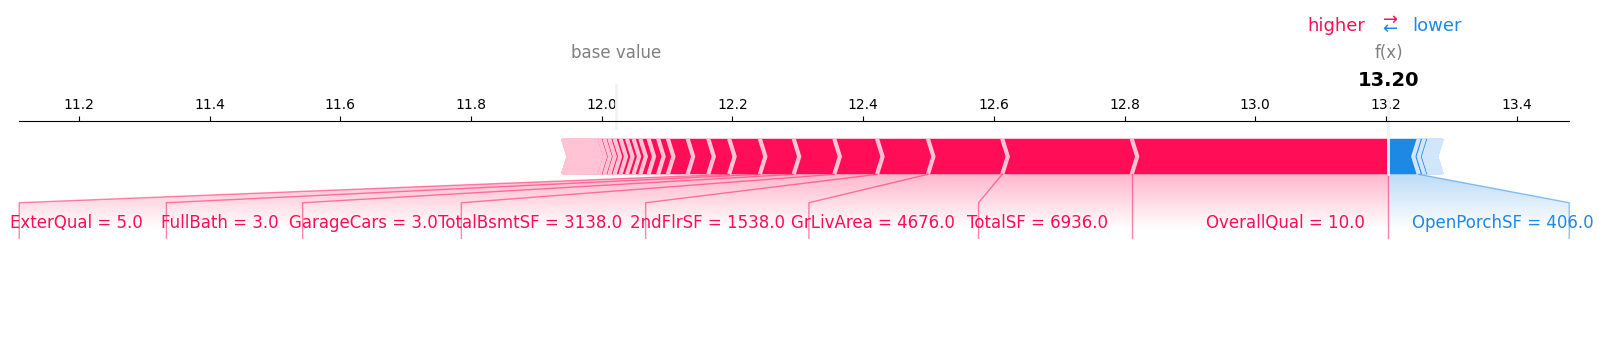

In [38]:
sample_df = data.loc[523,filtered_features]
shap_value = explainer.shap_values(sample_df.values.reshape(1, -1))

shap.force_plot(explainer.expected_value, shap_value, sample_df, matplotlib=True)

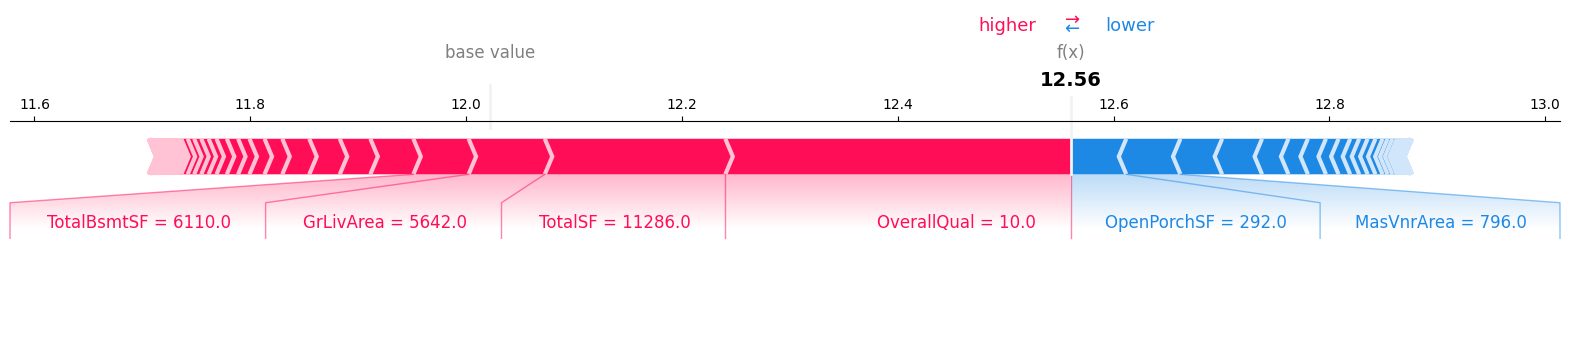

In [39]:
sample_df = data.loc[1298,filtered_features]
shap_value = explainer.shap_values(sample_df.values.reshape(1, -1))

shap.force_plot(explainer.expected_value, shap_value, sample_df, matplotlib=True)

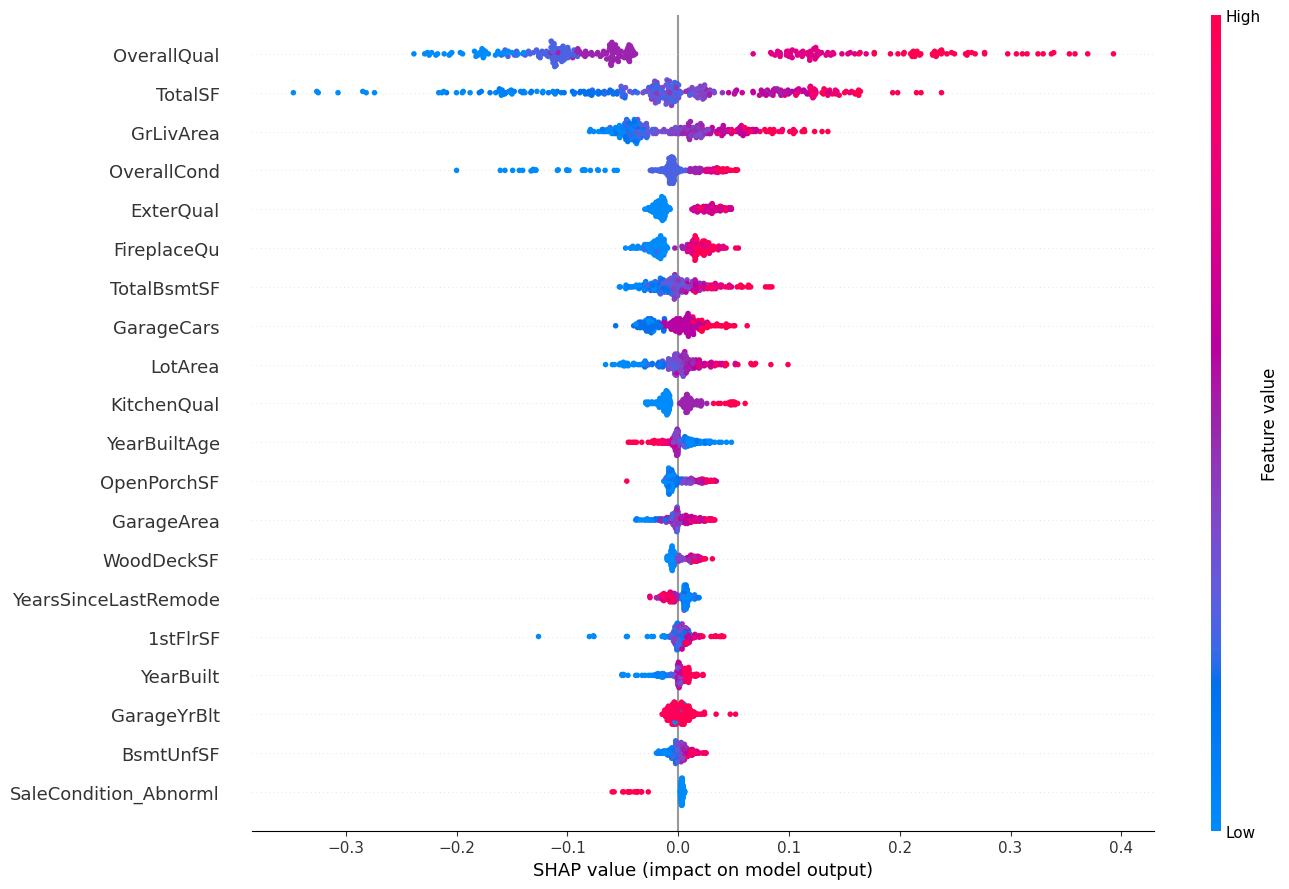

In [40]:
explainer = shap.TreeExplainer(gbr)
shap_values = explainer.shap_values(pd.DataFrame(np.array(X_test[filtered_features]),columns = filtered_features))

shap.summary_plot(shap_values, pd.DataFrame(np.array(X_test[filtered_features]),columns = filtered_features), plot_size=(14,9))

In [41]:
def create_new_features(df):
    df.loc[(df['OverallQual'] > 8) & (df['LandContour'] == 'Bnk'), 'OverallQual'] = df.loc[(df['OverallQual'] > 8) & (df['LotFrontage'] > 120)]['OverallQual'].apply(lambda x: x - 4)

    cols = ['YearBuilt', 'YearRemodAdd']
    for col in cols:
        df[col + 'Age'] = 2024 - df[col]

    df['YearsSinceLastRemode'] = df['YrSold'] - df['YearRemodAdd']

    df['TotalSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']

    df['TotalBathrooms'] = df['FullBath'] +  df['BsmtFullBath'] + (0.5 * df['HalfBath']) + (0.5 * df['BsmtHalfBath'])

    df['Ov_TS'] = df['OverallQual'] * df['TotalSF']

    df['TotalHomeQuality'] = df['OverallQual'] + df['OverallCond']

    df['Overall'] = (df['OverallCond'] * df.OverallQual)

    df['WOW'] = np.sqrt(df['Overall'] * df['GrLivArea'])

    df['LotArea_log'] = np.log1p(df['LotArea'])

    df["Spaciousness"] = (df['1stFlrSF'] + df['2ndFlrSF']) / df.TotRmsAbvGrd

    return df

In [42]:
def transform(df, drop_id=True, Test = False, outliers = False):

    if drop_id:
        df.reset_index(inplace=True, drop=True)
        df.drop(columns=['Id'], inplace=True)

    df = handle_missing(df)
    df = handle_numeric(df)
    df = create_new_features(df)
    df = handle_ordinal(df)
    df = handle_nominal(df)

    # Ne_list = [col for col in df.columns if col.find('Neighborhood') > -1]
    # Bs_list = [col for col in df.columns if col.find('BsmtQual') > -1]
    # Ms_list = [col for col in df.columns if col.find('MSZoning') > -1]
    # Sa_list = [col for col in df.columns if col.find('SaleCondition') > -1]

    # for i in Ne_list:
    #   df[i] = df[i].cat.codes * df['GrLivArea']

    # for i in Bs_list:
    #   df[i] = df[i].cat.codes * df['TotalBsmtSF']

    # for i in Ms_list:
    #   df[i] = df[i].cat.codes * df['GrLivArea']

    # for i in Sa_list:
    #   df[i] = df[i].cat.codes * df['GrLivArea']

    return df

In [43]:
data = pd.read_csv('C:\\Users\\이찬영\\Desktop\\House_Price\\train.csv')
sub = pd.read_csv('C:\\Users\\이찬영\\Desktop\\House_Price\\test.csv')
y = data['SalePrice']
data.drop(columns=['SalePrice'], inplace=True)
# sub['TotalBsmtSF'] = sub['TotalBsmtSF'].astype('Int64')

X_train, X_test, y_train, y_test = train_test_split(data.copy(), y, test_size=0.2, random_state=43, shuffle=True, stratify=None)
data = transform(data)
X_train = transform(X_train)
X_test = transform(X_test)
submission = transform(sub, Test = True)

gbr = GradientBoostingRegressor(**best_params, random_state=42)
gbr.fit(X_train[filtered_features], np.log(y_train))
pred_log = gbr.predict(X_test[filtered_features])
pred = np.exp(pred_log)
pred_vs_actual = pd.DataFrame(columns=['predicted', 'actual'])
pred_vs_actual['predicted'] = pred
pred_vs_actual['actual'] = list(y_test)
pred_vs_actual = pred_vs_actual.sort_values(by="actual").reset_index(drop=True)

fig = px.scatter(x=pred_vs_actual.index, y=pred_vs_actual.actual)
fig.add_scatter(x=pred_vs_actual.index, y=pred_vs_actual.predicted,  mode="markers")
fig.show()
acc_test = mean_squared_error(np.log(y_test), gbr.predict(X_test[filtered_features]), squared=False)
print (f'Accuracy test = {acc_test}')


Accuracy test = 0.13697272789372977


## Ansamble Model

In [44]:
data = pd.read_csv('C:\\Users\\이찬영\\Desktop\\House_Price\\train.csv')
sub = pd.read_csv('C:\\Users\\이찬영\\Desktop\\House_Price\\test.csv')
# sub['TotalBsmtSF'] = sub['TotalBsmtSF'].astype('Int64')
y = data['SalePrice']
data.drop(columns=['SalePrice'], inplace=True)
data = transform(data)
submission = transform(sub, Test = True)

gbr = GradientBoostingRegressor(**best_params, random_state=42)
gbr.fit(data[filtered_features], np.log(y))
gbm = lgb.train(gbm_best_params, lgb.Dataset(data, label=np.log(y)))
rdg = Ridge(alpha=14.93548147100569, solver='auto', random_state=42)
rdg.fit(data, np.log(y))

pred_gbr = np.exp(gbr.predict(submission[filtered_features]))
pred_gbm = np.exp(gbm.predict(submission))
pred_rdg = np.exp(rdg.predict(submission))

fin_score = 0.25 * pred_gbm + 0.25 * pred_gbr + 0.5 * pred_rdg

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5218
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 216
[LightGBM] [Info] Start training from score 12.024051


## Result

In [45]:
test_df = pd.read_csv('C:\\Users\\이찬영\\Desktop\\House_Price\\test.csv')

predictions_df = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': np.floor(fin_score)})
predictions_df.to_csv("C:\\Users\\이찬영\\Desktop\\House_Price\\submission\\Final_sub.csv", index=False)